In [1]:
import numpy as np

def eval_diff_eq(x: np.ndarray, b_coeffs: np.ndarray, a_coeffs: np.ndarray, max_out: int) -> np.ndarray:
    # Initialize the output array with zeros
    y = np.zeros(max_out)

    # M is the number of feed-forward delays (from b)
    # N is the number of feedback delays (from a)
    M = len(b_coeffs) - 1
    N = len(a_coeffs)

    for n in range(max_out):
        # 1. Non-recursive part: Sum of b[k] * x[n-k]
        for k in range(M + 1):
            if n - k >= 0 and n - k < len(x):
                y[n] += b_coeffs[k] * x[n - k]

        # 2. Recursive part: Subtract Sum of a[k] * y[n-k]
        # Note: In the ARMA formula, a1 corresponds to the delay y(n-1)
        for k in range(1, N + 1):
            if n - k >= 0:
                y[n] -= a_coeffs[k-1] * y[n - k]

    return y


# Define parameters
x_test = np.array([1, 2, 0, 2, 1])
b_test = np.array([0.25, 0.5, 0.25])
a_test = np.array([0.5])
max_samples = 6

# Run function
y_output = eval_diff_eq(x_test, b_test, a_test, max_samples)

print("Manual verification results:")
for i, val in enumerate(y_output):
    print(f"y({i}) = {val:.5f}")

Manual verification results:
y(0) = 0.25000
y(1) = 0.87500
y(2) = 0.81250
y(3) = 0.59375
y(4) = 0.95312
y(5) = 0.52344


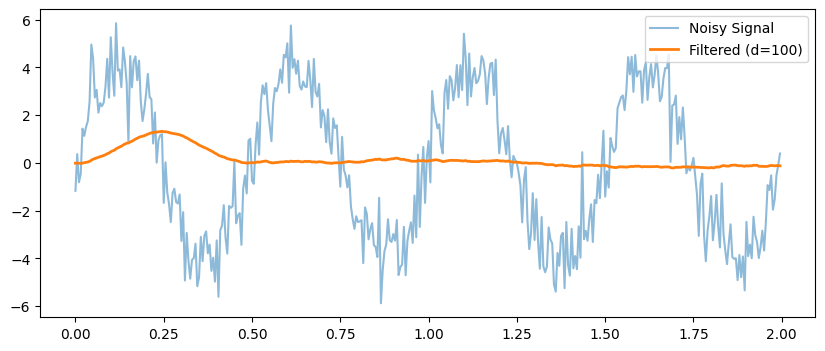

In [4]:
    from matplotlib import pyplot as plt

    # Parameters
    fs = 200
    t = np.linspace(0, 2, 2 * fs, endpoint=False)
    f_sine = 2
    amplitude = 4

    # Create clean and noisy signal
    clean_sine = amplitude * np.sin(2 * np.pi * f_sine * t)
    noise = np.random.randn(len(t))
    noisy_sine = clean_sine + noise

    # Moving Average Parameters
    d = 100# Try different values like 5, 20, 50
    b_ma = np.ones(d) / d
    a_ma = np.array([]) # No recursive part

    # Process
    filtered_sine = eval_diff_eq(noisy_sine, b_ma, a_ma, len(noisy_sine))

    # Plotting
    plt.figure(figsize=(10, 4))
    plt.plot(t, noisy_sine, label='Noisy Signal', alpha=0.5)
    plt.plot(t, filtered_sine, label=f'Filtered (d={d})', linewidth=2)
    plt.legend()
    plt.show()

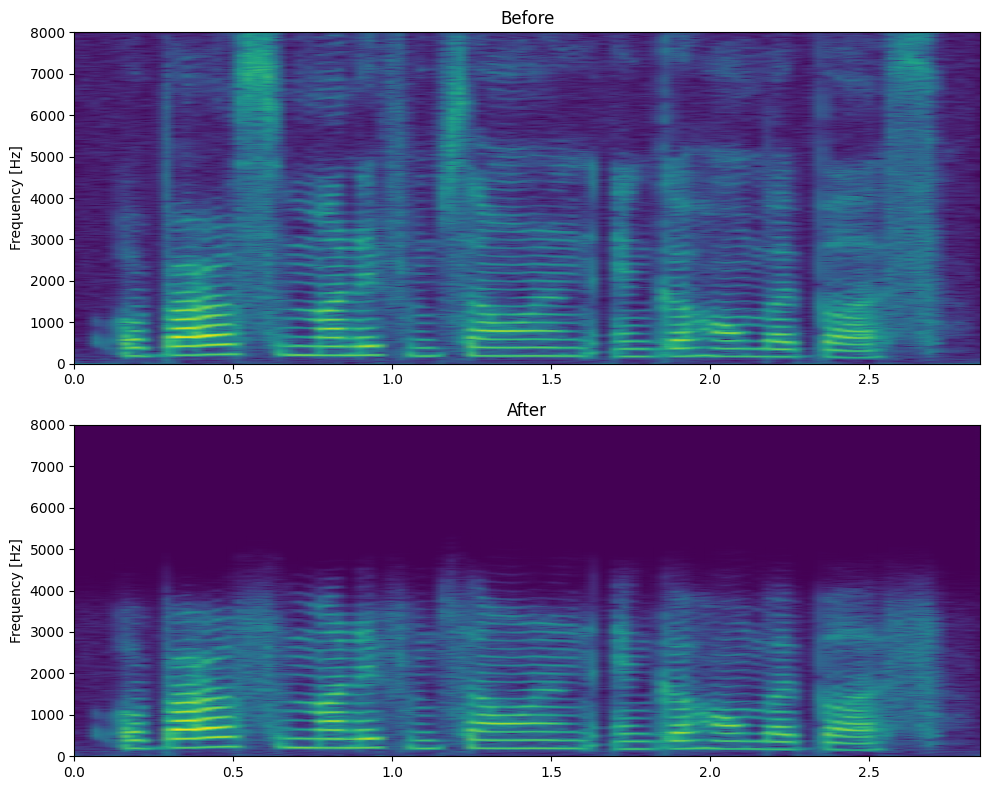

In [ ]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import lfilter, stft
import matplotlib.pyplot as plt

# 1. Load and Flatten
b_coeffs = np.load('../results/b_coeffs.npy').flatten()
a_coeffs = np.load('../results/a_coeffs.npy').flatten()

# 2. Load Audio
fs, speech_signal = wavfile.read('../data/speech1.wav')
if speech_signal.dtype == np.int16:
    speech_signal = speech_signal / 32768.0

# 3. Process (Optimized ARMA implementation)
# We add a '1' at the start of a_coeffs because lfilter expects
# the coefficient for y(n) to be the first element.
a_poly = np.concatenate(([1], a_coeffs))
processed_speech = lfilter(b_coeffs, a_poly, speech_signal)

# 4. Visualization (STFT)
def get_spec(sig, title):
    f, t, Zxx = stft(sig, fs, nperseg=1024)
    plt.pcolormesh(t, f, np.log10(np.abs(Zxx) + 1e-6), shading='gouraud')
    plt.title(title)
    plt.ylabel('Frequency [Hz]')

plt.figure(figsize=(10, 8))
plt.subplot(2,1,1); get_spec(speech_signal, "Before")
plt.subplot(2,1,2); get_spec(processed_speech, "After")
plt.tight_layout()
plt.show()

# 5. Save
wavfile.write('../results/audio/processed_speech.wav', fs, (processed_speech * 32767).astype(np.int16))